# Wind Data From NOAA's Rapid Refresh
---

**NOAA**: National Oceanic and Atmospheric Administration

**RAP**: Rapid Refresh  
Information can be found at the following url:
https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/rapid-refresh-rap

Data can be retrieved using the NetCDF Subset Service (NCSS). Information on this protocol are available at: https://www.unidata.ucar.edu/software/thredds/current/tds/reference/NetcdfSubsetServiceReference.html

The Rapid Refresh (RAP) numerical weather model is run by the National Centers for Environmental Prediction (NCEP), which is part of of the NOAA. Multiple data sources go into the generation of RAP model: commercial aircraft weather data, balloon data, radar data, surface observations, and satellite data. The model generates data down to a 13x13 squre kilometer resolution grid every hour. 

In [1]:
from powersimdata.input.grid import Grid
from prereise.gather.winddata.rap import rap, impute, helpers

import pandas as pd
from matplotlib import pyplot

## 1. Wind Farms in Network

In [2]:
grid = Grid(["Texas","Western"])
wind_farm = grid.plant.groupby("type").get_group("wind")

Reading bus.csv
Reading plant.csv
Reading gencost.csv
Reading branch.csv
Reading dcline.csv
Reading sub.csv
Reading bus2sub.csv
Reading zone.csv


In [3]:
wind_farm.head()

,bus_id,Pg,Qg,Qmax,Qmin,Vg,mBase,status,Pmax,Pmin,...,type,interconnect,GenFuelCost,GenIOB,GenIOC,GenIOD,zone_id,zone_name,lat,lon
plant_id,,,,,,,,,,,,,,,,,,,,,
10397,2010691,59.72,21.07,21.07,-14.24,1.0061,98.92,1,98.9,0.0,...,wind,Western,0.0,0.0,0.0,0,201,Washington,45.8131,-120.347
10400,2010699,79.42,-14.50,21.45,-14.50,1.0019,120.64,1,100.7,0.0,...,wind,Western,0.0,0.0,0.0,0,201,Washington,47.1356,-120.687
10401,2010703,136.30,29.03,29.03,-19.63,1.0623,174.64,1,136.3,0.0,...,wind,Western,0.0,0.0,0.0,0,201,Washington,45.8797,-120.807
10428,2010746,66.35,-12.96,19.17,-12.96,1.0205,98.26,1,90.0,0.0,...,wind,Western,0.0,0.0,0.0,0,201,Washington,46.9547,-120.182
10442,2010768,212.51,56.83,56.83,-38.42,1.0299,301.55,1,266.8,0.0,...,wind,Western,0.0,0.0,0.0,0,201,Washington,46.4211,-118.027


In [4]:
print("There are %d wind farms in the Western + Texas interconnection." % len(wind_farm))

There are 373 wind farms in the Western + Texas interconnection.


## 2. Downloading Data from NCEP's Server
Only few days are considered here. Note that some files on the server may be missing.

In [5]:
data, missing = rap.retrieve_data(wind_farm, start_date='2021-01-01', end_date='2021-01-15')

100%|██████████| 360/360 [13:02<00:00,  1.76s/it]


In [6]:
print("There are %d missing files." % len(missing))

There are 7 missing files.


In [7]:
data.head()

,plant_id,ts,ts_id,U,V,Pout
0,10397,2021-01-01 00:00:00,1,6.953803,-2.053628,0.394008
1,10400,2021-01-01 00:00:00,1,0.153802,-2.453629,0.013289
2,10401,2021-01-01 00:00:00,1,6.753802,-3.353629,0.426709
3,10428,2021-01-01 00:00:00,1,3.053802,1.246372,0.031360
4,10442,2021-01-01 00:00:00,1,2.953803,1.246372,0.028749


## 3. Plot Data
One wind farm is selected. The U and V components of the wind speed (in m/s) 80-m above ground along with the power output (in MW) are then plotted.

In [8]:
plant_id = 10400
data_oneplant = data[data.plant_id == plant_id].set_index("ts", drop=True).drop(
    ["plant_id", "ts_id"], axis=1) * wind_farm.loc[plant_id, "Pmax"]

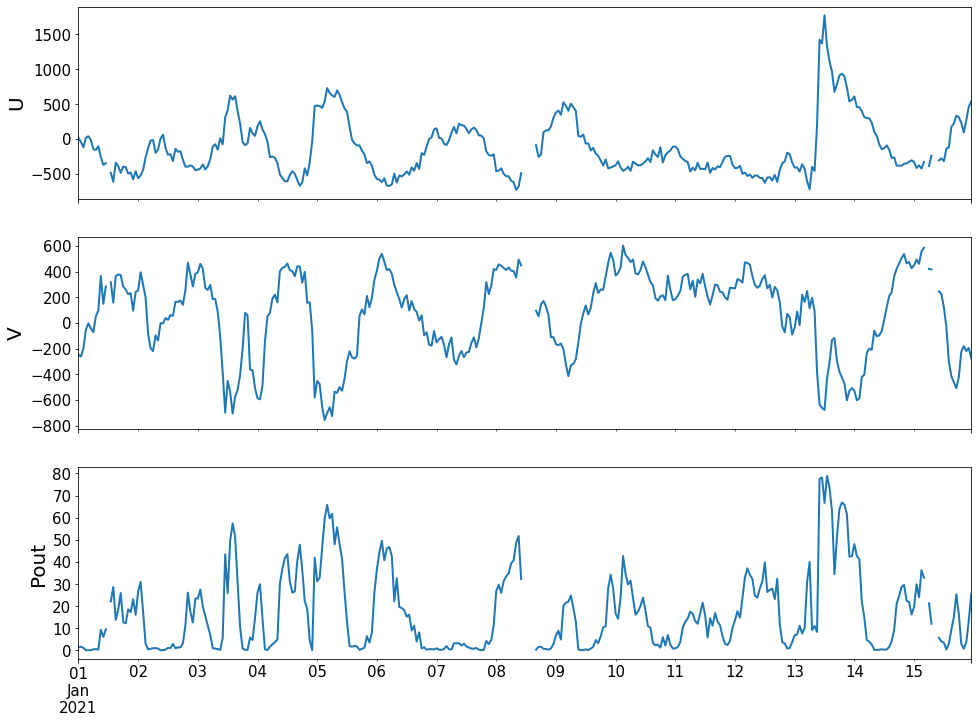

In [9]:
fig, ax = pyplot.subplots(nrows=3, ncols=1, sharex='col', figsize=(16,12))
for i, var in enumerate(['U','V','Pout']):
    data_oneplant.plot(y=var, ax=ax[i], legend=False, fontsize=15, lw=2)
    ax[i].set_xlabel('')
    ax[i].set_ylabel(var, fontsize=20)

pyplot.show()

## 4. Impute Missing Data
The missing data can be imputed inplace using the following simple procedure. In this case, there is nothing missing, so the plot will be identical.

In [10]:
impute.gaussian(data, wind_farm, inplace=True)

100%|██████████| 2611/2611 [00:03<00:00, 765.44it/s]


In [11]:
data_impute_oneplant = data[data.plant_id == plant_id]

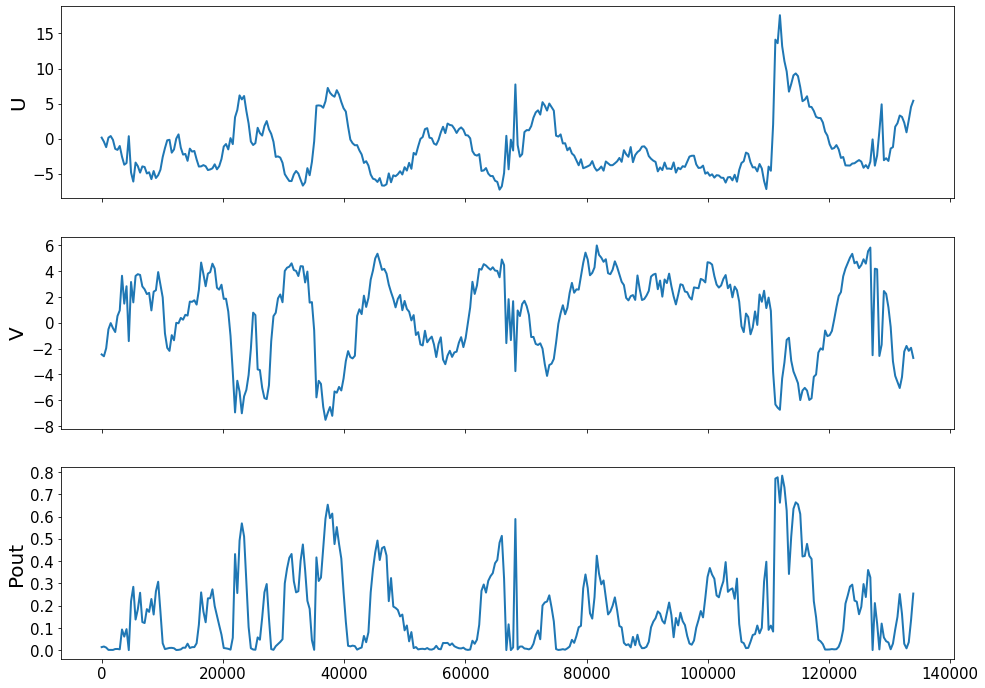

In [12]:
fig, ax = pyplot.subplots(nrows=3, ncols=1, sharex='col', figsize=(16,12))
for i, var in enumerate(['U','V','Pout']):
    data_impute_oneplant.plot(y=var, ax=ax[i], legend=False, fontsize=15, lw=2)
    ax[i].set_xlabel('')
    ax[i].set_ylabel(var, fontsize=20)

pyplot.show()

## 5. Format Data
Data are formated for REISE.

In [13]:
data_reise = helpers.to_reise(data)

In [14]:
data_reise.head()

,10397,10400,10401,10428,10442,10458,10463,10475,10522,10541,...,14040,14041,14042,14043,14044,14045,14046,14047,14048,14049
UTC,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.394008,0.013289,0.426709,0.031360,0.028749,0.050754,0.347244,0.660193,0.586084,0.363361,...,0.794428,0.559783,0.742298,0.531786,0.574248,0.574248,0.794417,0.467544,0.572619,0.645172
2021-01-01 01:00:00,0.437150,0.016064,0.398111,0.023123,0.045935,0.130048,0.396835,0.707745,0.668410,0.354086,...,0.784279,0.564544,0.712948,0.427363,0.596166,0.596166,0.747002,0.424119,0.597803,0.598318
2021-01-01 02:00:00,0.352485,0.011282,0.265297,0.006539,0.157918,0.125817,0.278846,0.687415,0.635291,0.207789,...,0.772045,0.530130,0.727762,0.434286,0.767840,0.767840,0.712261,0.492089,0.600031,0.398293
2021-01-01 03:00:00,0.245078,0.000859,0.173175,0.008885,0.302115,0.055242,0.162869,0.632597,0.593268,0.078567,...,0.768386,0.662062,0.726840,0.590540,0.748002,0.748002,0.792990,0.591421,0.582791,0.628879
2021-01-01 04:00:00,0.179390,0.000650,0.129466,0.004594,0.423158,0.076725,0.092887,0.598214,0.561667,0.030550,...,0.499822,0.719565,0.636132,0.636394,0.594090,0.594090,0.783140,0.565315,0.610985,0.584199
